In [57]:
import os
import requests
import matplotlib.pyplot as plt
import tarfile
import torch
import shutil

from enum import Enum
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import v2

In [58]:
class Pix2PixDataset(Enum):
        CITYSCAPES = 'cityscapes'
        EDGES2HANDBAGS = 'edges2handbags'
        EDGES2SHOES = 'edges2shoes'
        FACADES = 'facades'
        MAPS = 'maps'
        NIGHT2DAY = 'night2day'

        def num_epochs(self):
            print(self)
            match self:
                case Pix2PixDataset.CITYSCAPES:
                    return 200
                case Pix2PixDataset.EDGES2HANDBAGS:
                    return 15
                case Pix2PixDataset.EDGES2SHOES:
                    return 15
                case Pix2PixDataset.FACADES:
                    return 200
                case Pix2PixDataset.MAPS:
                    return 200
                case Pix2PixDataset.NIGHT2DAY:
                    return 17
                case _:
                    print("Invalid dataset")

        def batch_size(self):
            match self:
                case Pix2PixDataset.CITYSCAPES:
                    return 1
                case Pix2PixDataset.EDGES2HANDBAGS:
                    return 4
                case Pix2PixDataset.EDGES2SHOES:
                    return 4
                case Pix2PixDataset.FACADES:
                    return 1
                case Pix2PixDataset.MAPS:
                    return 1
                case Pix2PixDataset.NIGHT2DAY:
                    return 4
                case _:
                    print("Invalid dataset")
        
        def get_url(self):
            return f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{self.value}.tar.gz'

In [59]:
def download_dataset(dataset: Pix2PixDataset, path = './data'):
    url = dataset.get_url()
    if not os.path.exists(path):
        print("Creating data folder")
        os.makedirs(path)
    file_name = url.split('/')[-1]
    dataset_path = os.path.join(path, file_name)
    if not os.path.exists(path + '/' + dataset.value):
        print("Downloading the dataset {}".format(dataset_path))
        response = requests.get(url)
        with open(dataset_path, 'wb') as f:
            f.write(response.content)
        with tarfile.open(dataset_path, 'r') as tar:
            tar.extractall(path, filter='data')
            os.remove(dataset_path)

In [60]:
def remove_dataset(path):
    shutil.rmtree(path)

In [82]:
class ImageDataset(Dataset):    
    def __init__(self, dataset: Pix2PixDataset, test = False, val = False):
        self.dataset = dataset
        self.data_folder = './data'
        self.val = val
        self.test = test
        self.preprocess = v2.Compose([
            v2.Resize([286, 286]),
            v2.RandomCrop([256, 256]),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ToDtype(torch.float32, scale=True)])

    def load_dataset(self):
        self.__get_image_paths__()

    def __get_image_paths__(self):
        path = self.data_folder + '/' + self.dataset.value
        if self.test:
            path += '/test'
        else:
            path += '/train'
        if self.val:
            path += '/val'
        self.img_paths = []
        for root, _, fnames in sorted(os.walk(path)):
            for fname in fnames:
                img_path = os.path.join(root, fname)
                self.img_paths.append(img_path)
    
    def __getitem__(self,  index):
        img_path = self.img_paths[index]
        img = read_image(img_path)
        _, h, w = img.size()
        w2 = int(w/2)
        x = self.preprocess(v2.functional.crop(img, 0, w2, w2, h))
        y = self.preprocess(v2.functional.crop(img, 0, 0, w2, h))
        return x, y
    
    def __len__(self):
        self.__get_image_paths__()
        return len(self.img_paths)

In [83]:
dataset = ImageDataset(Pix2PixDataset.FACADES, test=True)
dataset.load_dataset()

In [84]:
download_dataset(Pix2PixDataset.FACADES)

In [85]:
item = dataset.__getitem__(0)

[]

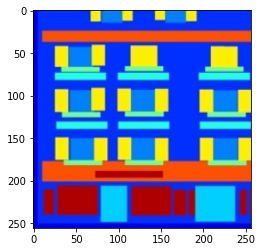

In [89]:
plt.imshow(item[0].permute(1, 2, 0))
plt.plot()

[]

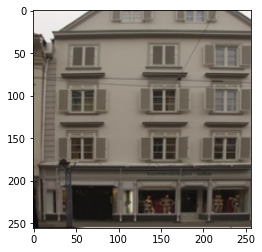

In [90]:
plt.imshow(item[1].permute(1, 2, 0))
plt.plot()

In [91]:
plt.imshow(dataset.preprocess(item['x']).permute(1, 2, 0))
plt.plot()

TypeError: tuple indices must be integers or slices, not str

In [92]:
epochs = Pix2PixDataset.EDGES2SHOES.num_epochs()
batch_size = Pix2PixDataset.EDGES2SHOES.batch_size()
print("epochs: {}, batch size: {}".format(epochs, batch_size))

Pix2PixDataset.EDGES2SHOES
epochs: 15, batch size: 4


In [93]:
dataset.__len__()

106

In [94]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset=dataset, batch_size=Pix2PixDataset.FACADES.batch_size(), shuffle=True)

In [95]:
inputs, targets = next(iter(dataloader))

In [97]:
inputs.shape

torch.Size([1, 3, 256, 256])

In [98]:
targets.shape

torch.Size([1, 3, 256, 256])